# Plot the correlation length

In [1]:
using DIVAnd
using ColorSchemes
using NCDatasets
using GeoDatasets
using CairoMakie, GeoMakie
using GeometryOps, GeoInterface
using JupyterFormatter
enable_autoformat()
include("./config.jl")

[ Info: Downloading file 'lsmask_5min_i.bin' from 'https://raw.githubusercontent.com/matplotlib/basemap/v1.2.2rel/lib/mpl_toolkits/basemap/data/lsmask_5min_i.bin' with cURL.
[ Info: Downloading file 'gshhg-shp-2.3.7.zip' from 'http://www.soest.hawaii.edu/pwessel/gshhg/gshhg-shp-2.3.7.zip' with cURL.


plot_field_var_fast (generic function with 3 methods)

In [31]:
depthr = Float64[
    0,
    5,
    10,
    15,
    20,
    25,
    30,
    35,
    40,
    45,
    50,
    55,
    60,
    65,
    70,
    75,
    80,
    85,
    90,
    95,
    100,
    125,
    150,
    175,
    200,
    225,
    250,
    275,
    300,
    325,
    350,
    375,
    400,
    425,
    450,
    475,
    500,
    550,
    600,
    650,
    700,
    750,
    800,
    850,
    900,
    950,
    1000,
    1050,
    1100,
    1150,
    1200,
    1250,
    1300,
    1350,
    1400,
    1450,
    1500,
    1550,
    1600,
    1650,
    1700,
    1750,
    1800,
    1850,
    1900,
    1950,
    2000,
    2100,
    2200,
    2300,
    2400,
    2500,
    2600,
    2700,
    2800,
    2900,
    3000,
    3100,
    3200,
    3300,
    3400,
    3500,
    3600,
    3700,
    3800,
    3900,
    4000,
    4100,
    4200,
    4300,
    4400,
    4500,
    4600,
    4700,
    4800,
    4900,
    5000,
    5100,
    5200,
    5300,
    5400,
    5500,
]

102-element Vector{Float64}:
    0.0
    5.0
   10.0
   15.0
   20.0
   25.0
   30.0
   35.0
   40.0
   45.0
   50.0
   55.0
   60.0
    ⋮
 4400.0
 4500.0
 4600.0
 4700.0
 4800.0
 4900.0
 5000.0
 5100.0
 5200.0
 5300.0
 5400.0
 5500.0

## Load bathymetry 

In [2]:
topodir = "/home/ctroupin/data/GEBCO/"
topofile = joinpath(topodir, "gebco_30sec_16.nc")
bx, by, b = DIVAnd.extract_bath(topofile, true, lonr, latr)
b[b.<0.0] .= NaN;

lon_landsea, lat_landsea, landsea = GeoDatasets.landseamask(; resolution = 'i', grid = 5)
landsea[landsea.==2] .= 1;

### Create and edit mask

In [3]:
xi, yi, mask = load_mask(topofile, true, lonr, latr, 0.0);
coordinatelist = read_polygon_json("./mask.json");
edit_mask!(xi, yi, mask, coordinatelist)

### Read horizontal correlation length

In [7]:
CLfile = "/home/ctroupin/data/EMODnet-Chemistry/correlation_len_0.25.nc"
isfile(CLfile)
ds = NCDataset(CLfile, "r")
CL = ds["correlation_length"][:, :]
close(ds)
CL[mask.==0] .= NaN

Dataset: /home/ctroupin/data/EMODnet-Chemistry/correlation_len_0.25.nc
Group: /

Dimensions
   lon = 461
   lat = 237

Variables
  correlation_length   (461 × 237)
    Datatype:    Float64 (Float64)
    Dimensions:  lon × lat



closed Dataset

### Vertical correlation length

In [32]:
lenz = min.(max.(25.0, depthr ./ 10), 500.0);

102-element Vector{Float64}:
  25.0
  25.0
  25.0
  25.0
  25.0
  25.0
  25.0
  25.0
  25.0
  25.0
  25.0
  25.0
  25.0
   ⋮
 440.0
 450.0
 460.0
 470.0
 480.0
 490.0
 500.0
 500.0
 500.0
 500.0
 500.0
 500.0

## Make the plot

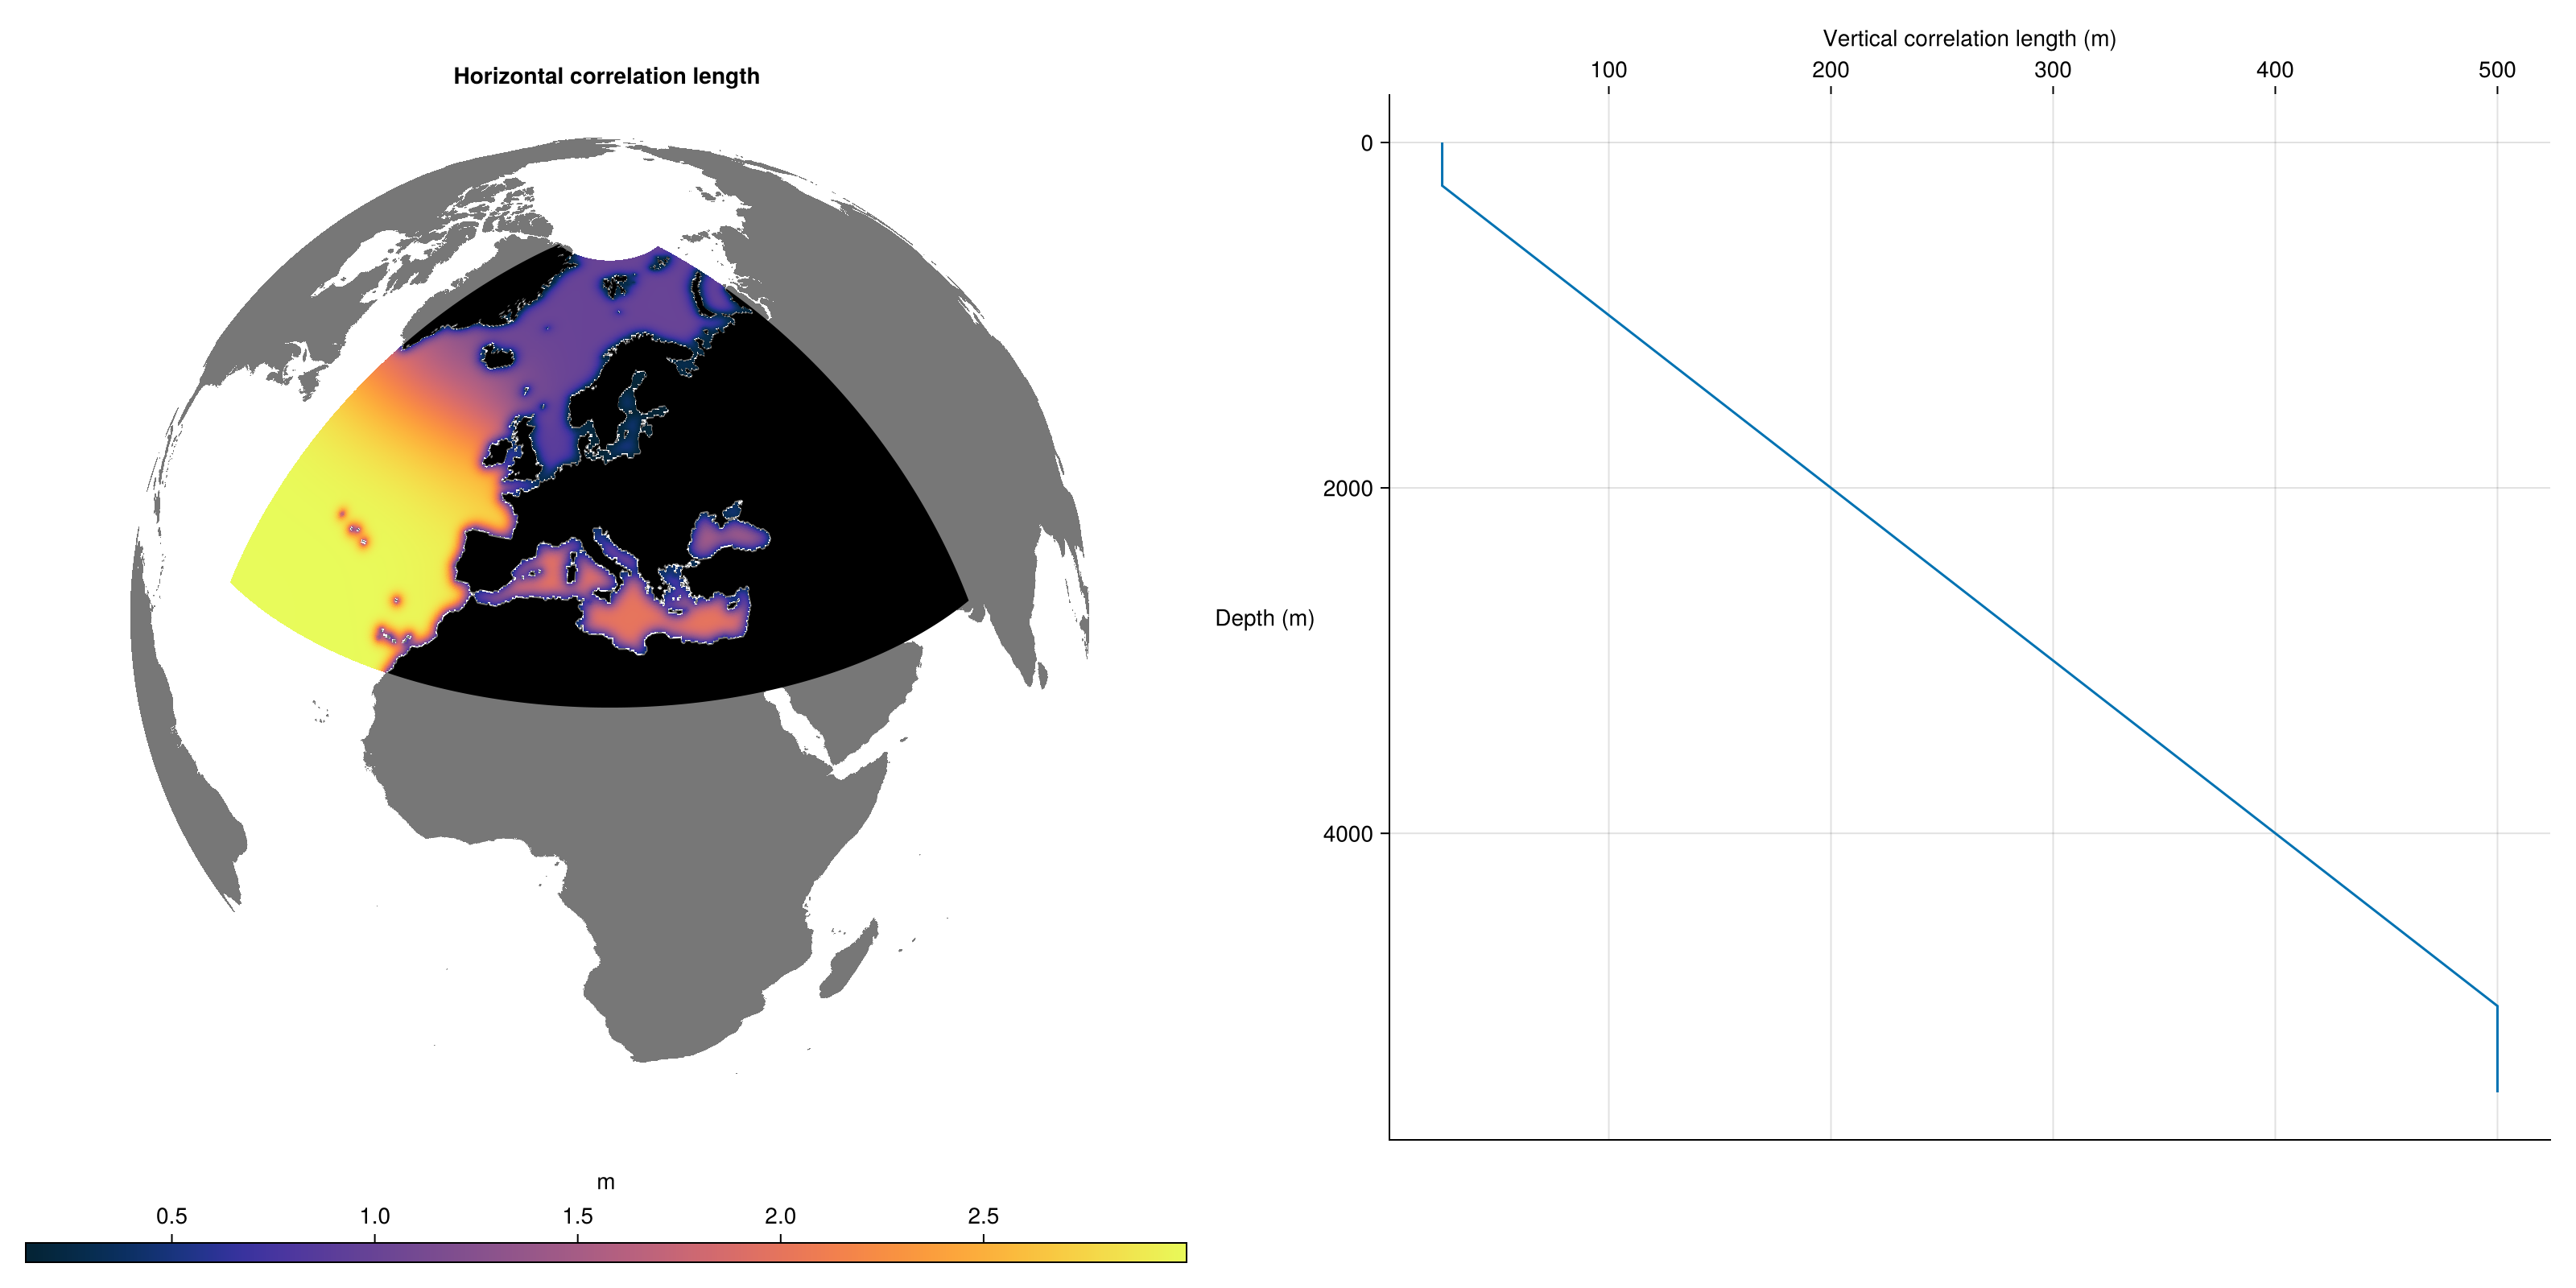

CairoMakie.Screen{IMAGE}


In [40]:
fig = Figure(size = (1600, 800))
ga = GeoAxis(
    fig[1, 1],
    title = "Horizontal correlation length",
    dest = "+proj=ortho +lon_0=15 +lat_0=35",
)

surface!(
    ga,
    lon_landsea,
    lat_landsea,
    landsea,
    colormap = Reverse(:greys),
    colorrange = [0, 2],
    shading = NoShading,
)
hm = surface!(ga, lonr, latr, CL, shading = NoShading, colormap = :thermal)
Colorbar(fig[2, 1], hm, label = "m", labelrotation = 0, vertical = false)

masklayer = contourf!(ga, xi, yi, mask, levels = [0.0, 0.0001], colormap = Reverse(:binary))

#xlims!(ga, -180, 180.0)
#ylims!(ga, -90.0, 90.0)
hidedecorations!(ga)

ax2 = Axis(
    fig[1, 2],
    xaxisposition = :top,
    xlabel = "Vertical correlation length (m)",
    ylabel = "Depth (m)",
    ylabelrotation = 0,
    yreversed = true,
)
lines!(ax2, lenz, depthr)
hidespines!(ax2, :b, :r)
save(joinpath(figdir, "correlation_length.png"), fig)
# display(fig)